# Определение именованных сущностей в рецептах

* [1] https://open.blogs.nytimes.com/2015/04/09/extracting-structured-data-from-recipes-using-conditional-random-fields
* [2] https://open.blogs.nytimes.com/2016/04/27/structured-ingredients-data-tagging
* [3] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
* [4] https://pytorch.org/tutorials/beginner/saving_loading_models.html
* [5] https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
* [6] https://en.wikipedia.org/wiki/Named-entity_recognition

На сегодняшнем семинаре мы рассмотрим задачу поиска именованных сущностей в тексте на примере рецептов еды, а также обучим нейросеть LSTM, которая будет автоматически делать эту задачу за нас. 

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')
# Для выполнения этого задания не забудьте установить:
# !pip3 install spacy_udpipe
# !pip3 install ipymarkup
# !pip3 install livelossplot

import warnings
warnings.filterwarnings('ignore')
import pandas as pd

У нас есть CSV-файл, в котором содержатся строки из рецептов блюд на английском языке, а также пояснения к этим рецептам. В колонке "input" у нас строка с рецептом блюда, в колонке "name" — название основного продукта в этом блюде, в колонках "quantity" и "range_end" содержится информация о количестве этого продукта в блюде, колонка "unit" отвечает за единицу измерения. В первом и во втором рецепте это — количество в "чашках", в последнем рецепте это "столовые ложки". Колонка "комментарий" отвечает за дополнительные сведения о приготовлении блюда. Для этого семинара мы перевели наш файл с рецептами в формат BIO, когда каждому слову соответствует тэг, и взяли из него первые 50 тысяч рецептов. 

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
df = pd.read_csv('datasets/nyt-ingredients-head.csv')
df[0:5]

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


## Аннотированные (BIO) рецепты

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
datafile = 'datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

#### словарь и тэги:

In [5]:
from dlnlputils.recipe_utils import form_vocabulary_and_tagset, prepare_data, show_markup, Converter, tag_statistics, plot_confusion_matrix, recipe_statistics, plot_recipe_statistics
vocabulary,labels = form_vocabulary_and_tagset(lines)

#### рецепты:

In [6]:
recipes_w_tags = prepare_data(lines)

print(len(recipes_w_tags))
test_recipe, test_tags = recipes_w_tags[0]
show_markup(test_recipe, test_tags)

49847


#### перевод слов и тэгов в индексы - и обратно:

Формат BIO подразумевает, что каждая именованная сущность может состоять из нескольких слов: "b" — beginning, "inter" — это продолжение. В данном случае именная сущность "комментарий" состоит из четырёх слов, именованная сущность "тыква" (а именно её вид) состоит из двух слов, сущность под названием "комментарии" состоит из трёх слов, где "peeled" — это начало, а это — продолжение. 

Обучим нейросеть LSTM на наших размеченных данных. Нейросети не умеют принимать на вход слова, они умеют принимать на вход числа, поэтому мы построим два индексных словаря — для слов, которые содержатся в рецептах, и для их тэгов. Для этого мы определим объект "конвертер" и рассмотрим пример, как он работает. Исходный рецепт выглядит следующим образом — в сконвертированном виде каждому слову будут соответствовать некие индексы в словаре (и так далее), каждому тэгу будет соответствовать индекс в словаре тэгов. Наш конвертор работает правильно, поэтому при обратной конвертации мы не теряем нашу информацию. Мы разделим наши 50000 рецептов на две части: первые 40 тысяч мы будем использовать для тренировки нейросети, оставшиеся 10 тысяч — для оценки её точности.


In [7]:
converter = Converter(vocabulary,labels)

test_recipe, test_tags = recipes_w_tags[0]


encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



In [8]:
training_data = recipes_w_tags[:40000]
test_data = recipes_w_tags[40000:]

## LSTM

In [9]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

Определим нейросеть LSTM с помощью фреймворка PyTorch. Для входящих слов — например, трёх слов "cup", "of", "tea", мы найдём их индексы в словаре, далее — соответствующие им векторы в эмбеддинг-матрице. Далее, каждый из этих векторов попадёт в нашу нейросеть LSTM следующим образом: сначала попадает первый вектор, нейросеть генерирует некий промежуточный результат и получает его же себе на вход одновременно с вектором следующего слова, производит ещё один промежуточный результат, получит его на вход с вектором уже следующего слова, и для каждого такого промежуточного состояния мы применяем модуль, связанный с предсказанием тэга. В данном случае, для вектора "cup" это будет тэг "quantity", для "of" это будет "comment", для "tea" наш модуль предскажет "name".

In [10]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

Какие из следущих методов можно использовать для принятия решения об объединении нескольких слов в именованную сущность?  
+pmi(l,w)=log (p(w,l)/p(w)p(l))  
+Частота n-граммы  
+Языковая модель (например, skip-gram)  

Зачем в функции predict_tags() мы делаем вызов torch.no_grad()?  
+для деактивации autograd (без вычисления градиентов будет использоваться меньше памяти и скорость работы увеличится)

In [11]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.1)

Мы определили нашу нейросеть LSTM, задали функцию потерь, и, наконец, запустим процесс обучения нейросети. Каждые 500 шагов на график добавляется новая точка, соответствующая значению функции потерь в этот момент.  

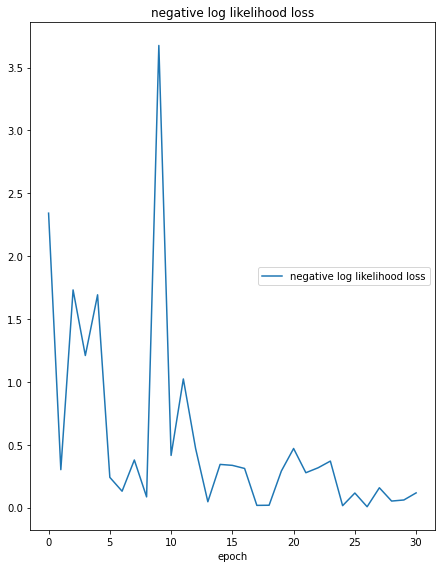

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.007, max:    3.676, cur:    0.117)


In [12]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(1): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        
        tag_scores = model(encoded_recipe)

        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 500 == 0:
            loss_np = loss.detach().numpy()
            liveplot.update({'negative log likelihood loss': loss_np})
            liveplot.draw()
            
            
        if i == 15000:
            break

Наша нейросеть закончила обучение на тренировочных данных, и теперь мы можем использовать её для предсказания тэгов на рецептах, которых она ранее никогда не видела. Для этого определим функцию predict_tags. Она работает следующим образом. Опять же, нейросеть (на этот раз уже обученная) получает на вход слова, находятся их индексы в словаре, они попадают в нейросеть, и мы предсказываем тэги для слов. 

In [13]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

Рассмотрим 10 реальных примеров предсказания тэгов рецептов. На экране вы видите настоящие тэги, которые мы взяли из нашего файла, и тэги предсказанные. Мы видим, что наша нейросеть не допустила ошибок на случайно выбранных 10 рецептах, кроме вот этого рецепта, — а именно, длинный тэг "name" для последовательности из трёх слов она разбила на две части — "comment" и "name".

In [14]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Save & Load model

In [15]:
'''
torch.save(model.state_dict(), 'models/recipe.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('models/recipe.pt'))
model.eval()


recipe, tags = test_data[4444]

tags_pred = predict_tags(model, recipe)

print('ground truth:')
print(list(zip(recipe, tags)))
print()

print('prediction:')
print(list(zip(recipe, tags_pred)))   


print('ground truth:')
show_markup(recipe, tags)

print('prediction:')
show_markup(recipe, tags_pred)
'''
print()

## Проверка возможностей нейросети на тестовых данных:

Теперь попробуем оценить качество нашей нейросети на всех рецептах, которые у нас остались в тестовом датасете. Для этого мы построим матрицу ошибок, а также посмотрим на пару других интересных метрик. Во-первых, посмотрим на качество предсказания тэгов. 

### Количество верно предсказанных тэгов:

In [16]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для B-QTY:
  корректно:	 8266
      всего:	 8420
% корректно:	 98.1710213776722

для B-COMMENT:
  корректно:	 5366
      всего:	 7823
% корректно:	 68.59261153010354

для B-RANGE_END:
  корректно:	 113
      всего:	 156
% корректно:	 72.43589743589743

для B-UNIT:
  корректно:	 6787
      всего:	 7074
% корректно:	 95.94288945433985

для B-NAME:
  корректно:	 8728
      всего:	 10278
% корректно:	 84.91924498929752

для I-NAME:
  корректно:	 4336
      всего:	 5528
% корректно:	 78.43704775687411

для I-COMMENT:
  корректно:	 13713
      всего:	 14984
% корректно:	 91.51761879337961

для OTHER:
  корректно:	 1964
      всего:	 4101
% корректно:	 47.89075835162156

----------
в итоге:
  корректно:	 49273
      всего:	 58364
% корректно:	 84.42361729833459


Например, тэг, соответствующий названию продукта (B-NAME точнее началу, потому что название продукта может состоять из нескольких слов), предсказывается в 89% корректно. Тэг, соответствующий продолжению названия продукта, предсказывается почти в 79% корректно. 

### Матрица Ошибок (Confusion Matrix)

Для того, чтобы понять, как именно наша нейросеть ошибается и какие тэги она путает с какими, мы построим матрицу ошибок. Итак, в первой матрице мы видим столбец, соответствующий истинным значениям тэгов, и строку, отвечающую за предсказанный тэг. Например, тэг "quantity" был предсказан верно 8285 раз и ошибочно был предсказан: как "комментарий" (22 раза), как "название продукта" (18 раз) и как "продолжение комментария" (95 раз). Тэг, обозначающий "единицу измерения продукта" был предсказан верно почти во всех случаях, однако нейросеть перепутала его с "комментарием" 59 раз, с продолжением "названия продукта" 10 раз, с началом "названия продукта" 21 раз. Посмотрим на эту же матрицу ошибок, где значение выводится в процентном соотношении. Мы видим то, что некоторые тэги предсказаны с довольно высокой точностью: 98%, 99%, 90%, 91%... Однако же у нас есть и тэг, который нейросеть предсказывает довольно плохо — можно сказать, угадывает его в 50% случаев.

In [17]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

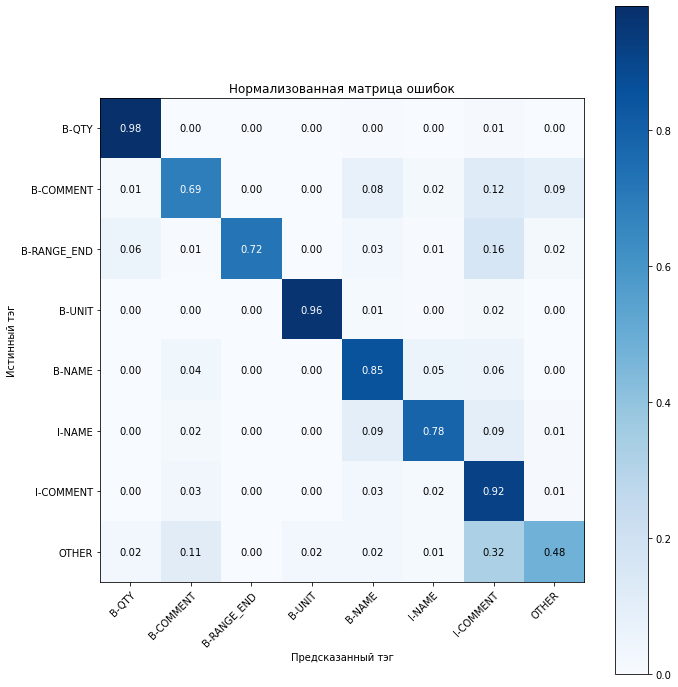

In [19]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()

### Количество верно размеченных рецептов:

Следом за матрицей ошибок постараемся понять, в скольких примерах наша нейросеть безукоризненно предсказывает все тэги в предложениях, в каких предложениях она ошибается один раз, два раза, и так далее. Мы видим то, что почти 7000 рецептов наша нейросеть разметила без каких-либо ошибок, то есть не сделала ошибки ни в одном тэге. Примерно по 1200-1300 предложений, в которых нейросеть допустила одну или две ошибки. И около 500 предложений, в которых нейросеть допустила три ошибки, и далее по убывающей. Опять же, в процентном соотношении, мы можем оценить ошибки нашей сети. Рассмотрим этот же график, где вместо абсолютных значений используется процентное соотношение. Около 70% предложений размечены без ошибок, чуть больше 10% размечено предложений с одной или двумя ошибками, и далее по убывающей

In [20]:
correct_recipes, total_recipes = recipe_statistics(model, converter, test_data, 4)

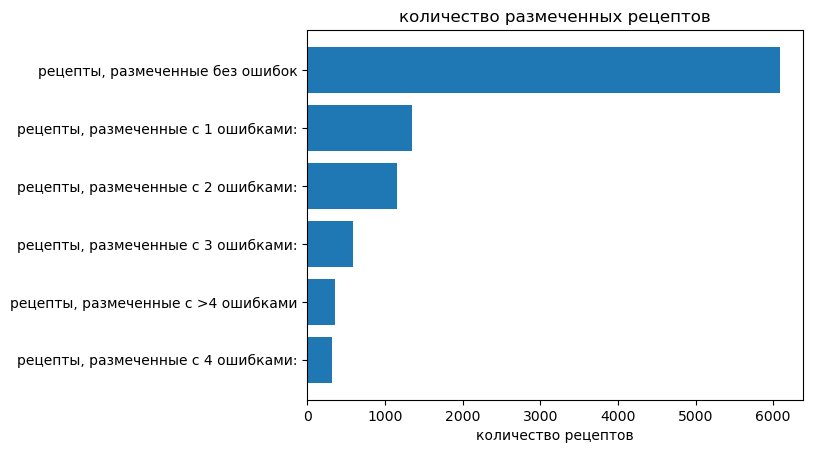

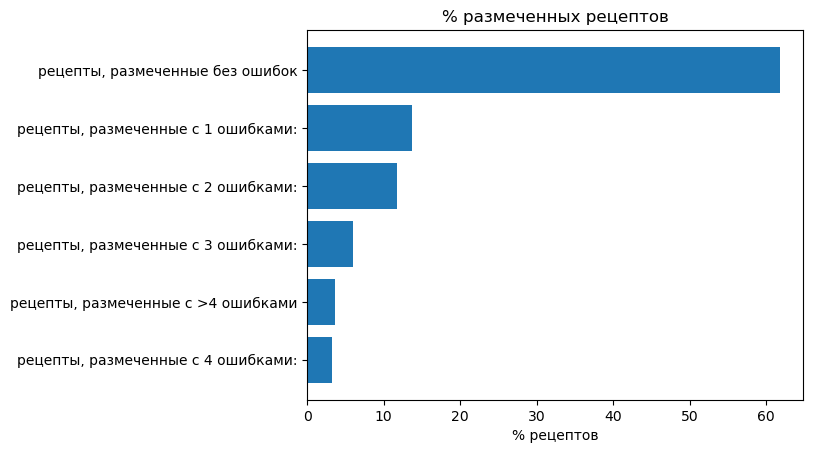

In [21]:
plot_recipe_statistics(correct_recipes)
plot_recipe_statistics(correct_recipes, total_recipes)